# Reconstruction Error analysis for any new set of GT sequences

This notebook contains all the steps necessary to calculate the RE and FAS scores and generate plots for sequences from any new GT family of unknown fold. It is advised to have as many sequences from each of the new families as possible with at most 95% sequence similarity between them.<br>
This step can be run using the outputs from 1-Preprocessing.ipynb

## 1. Imports, functions and constants

In [1]:
import os

from CNN import *
from Utils_auto import *
from Utils import *
from Autoencoder import *

from sklearn import preprocessing

In [2]:
## Constants

# Vocabulary for ss prediction
vocab = {'C': [0,0,1], 'H': [0,1,0], 'E': [1,0,0], '-':[0,0,0]}

# Transform the labels from String to Integer via LabelEncoder
le_fold = preprocessing.LabelEncoder()
le_fam = preprocessing.LabelEncoder()

# Defining cluster names
grp=['gta0','gta1','gtb0','gtb1','gtb2','gtc0','gtc1','gtc2','gtlyso']

# Define criterion and read in the models for each subcluster
criterion = nn.MSELoss(reduction="sum")

# use of GPU
cuda_gpu=False

## Reading saved models and RE for GT-A, -B, -C and -lyso sequences

In [3]:
# Reading the main autoencoder model
f=open( "../PretrainedModels/Autoencoder_gtmain.pickle", "rb" )
model_main = CPU_Unpickler(f).load()

# Reading the 9 cluster autoencoder models
model=dict()
for i in grp:
    f=open( "../PretrainedModels/Autoencoder_"+i+".pickle", "rb" )
    model[i] = CPU_Unpickler(f).load()

# Reading the RE data for training sequences from the main autoencoder
re_train_main=pd.read_csv("../Datasets/RE_data/rerr_gtmain_training.csv")

# Reading the RE data for training, OOC and OOF sequences from the cluster autoencoders
re_train=dict()
re_ooc=dict()
re_oof=dict()
for i in grp:
    train="../Datasets/RE_data/rerr_"+i+"_training.csv"
    ooc="../Datasets/RE_data/rerr_"+i+"_ooc.csv"
    oof="../Datasets/RE_data/rerr_"+i+"_oof.csv"
    re_train[i]=pd.read_csv(train)
    re_ooc[i]=pd.read_csv(ooc)
    re_oof[i]=pd.read_csv(oof)

## Reading processed tables for new set of sequences

In [4]:
# Read in the test dataset
df_test=pd.read_csv("../Datasets/gtu/gtu.processed.csv")
df_test.shape

(4072, 8)

In [5]:
df_test.head()

Name fold  family  \
0              GT69-u|AAY89392|C.gattiiVGIR265_Fungi    u  GT69-u   
1                 GT69-u|AAC13946|C.neoformans_Fungi    u  GT69-u   
2  GT73-u|AIE00872|K.pneumoniaesubsppneumoniaeKP5...    u  GT73-u   
3               GT48-u|ABX80511|C.parapsilosis_Fungi    u  GT48-u   
4          GT48-u|AAF34719|C.glabrataATCC90876_Fungi    u  GT48-u   

                                               q3seq  \
0  ----------------------------------------------...   
1  ----------------------------------------------...   
2  ----------------------------------------------...   
3  ----------------------------------------------...   
4  ----------------------------------------------...   

                                              rawseq  \
0  ----------------------------------------------...   
1  ----------------------------------------------...   
2  ----------------------------------------------...   
3  ----------------------------------------------...   
4  ----------------------------------------------...   

                                         q3seqTokens  \
0  ['-', '-', '-', '-', '-', '-', '-', '-', '-', ...   
1  ['-', '-', '-', '-', '-', '-', '-', '-', '-', ...   
2  ['-', '-', '-', '-', '-', '-', '-', '-', '-', ...   
3  ['-', '-', '-', '-', '-', '-', '-', '-', '-', ...   
4  ['-', '-', '-', '-', '-', '-', '-', '-', '-', ...   

                                        rawseqTokens  paddings  
0  ['-', '-', '-', '-', '-', '-', '-', '-', '-', ...       306  
1  ['-', '-', '-', '-', '-', '-', '-', '-', '-', ...       170  
2  ['-', '-', '-', '-', '-', '-', '-', '-', '-', ...       248  
3  ['-', '-', '-', '-', '-', '-', '-', '-', '-', ...        46  
4  ['-', '-', '-', '-', '-', '-', '-', '-', '-', ...        47

## RE calculation and analysis against main autoencoder

In [6]:
# Calculate RE against main autoencoder
# This step can take long; 
# To avoid, load already provided dataset by uncommenting last line of this block 
# and comment the line below
re_test_main = reconstruction_error_calculation(model_main, df_test, le_fam, le_fold, cuda_gpu, criterion, vocab)

### re_test_main=pd.read_csv("../Datasets/gtu/gtu.RE_main.csv")

/Users/rtaujale/opt/anaconda3/envs/GTstrML/lib/python3.7/site-packages/torch/nn/functional.py:1639: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


In [7]:
# Calculate median RE for every family
re_test_main_median=re_test_main.groupby('Family').median().reset_index().sort_values('Err')
re_test_main_median

Family       Err
16   GT53-u  0.084841
4   GT105-u  0.085035
10  GT110-u  0.087367
22   GT89-u  0.091285
21   GT76-u  0.091351
5   GT106-u  0.093037
8   GT109-u  0.096032
12   GT29-u  0.098119
3   GT103-u  0.102328
6   GT107-u  0.102565
17   GT69-u  0.102770
2   GT102-u  0.104105
18   GT71-u  0.104204
13   GT42-u  0.107304
28   GT98-u  0.107749
1   GT101-u  0.111683
25   GT95-u  0.113756
9    GT11-u  0.114253
14   GT44-u  0.114815
0   GT100-u  0.115246
15   GT48-u  0.116406
24   GT92-u  0.116445
29   GT99-u  0.120120
20   GT74-u  0.120559
19   GT73-u  0.125388
26   GT96-u  0.130178
11   GT26-u  0.132333
23   GT91-u  0.136016
27   GT97-u  0.146374
7   GT108-u  0.281884

In [8]:
# Save RE for the test dataset to file
re_test_main.to_csv("../ExampleOutputs/gtu.RE_main.csv",index=False)

In [9]:
# Save median RE to a file
re_test_main_median.to_csv("../ExampleOutputs/gtu.medianRE_main.csv",index=False)

### RE analysis for main autoencoder

#### Fit extreme value distribution to the training error distribution

95% CI upper bound: 0.10659970165381911
99% CI upper bound: 0.14685000308245982
Median RE: 0.10390086844563484


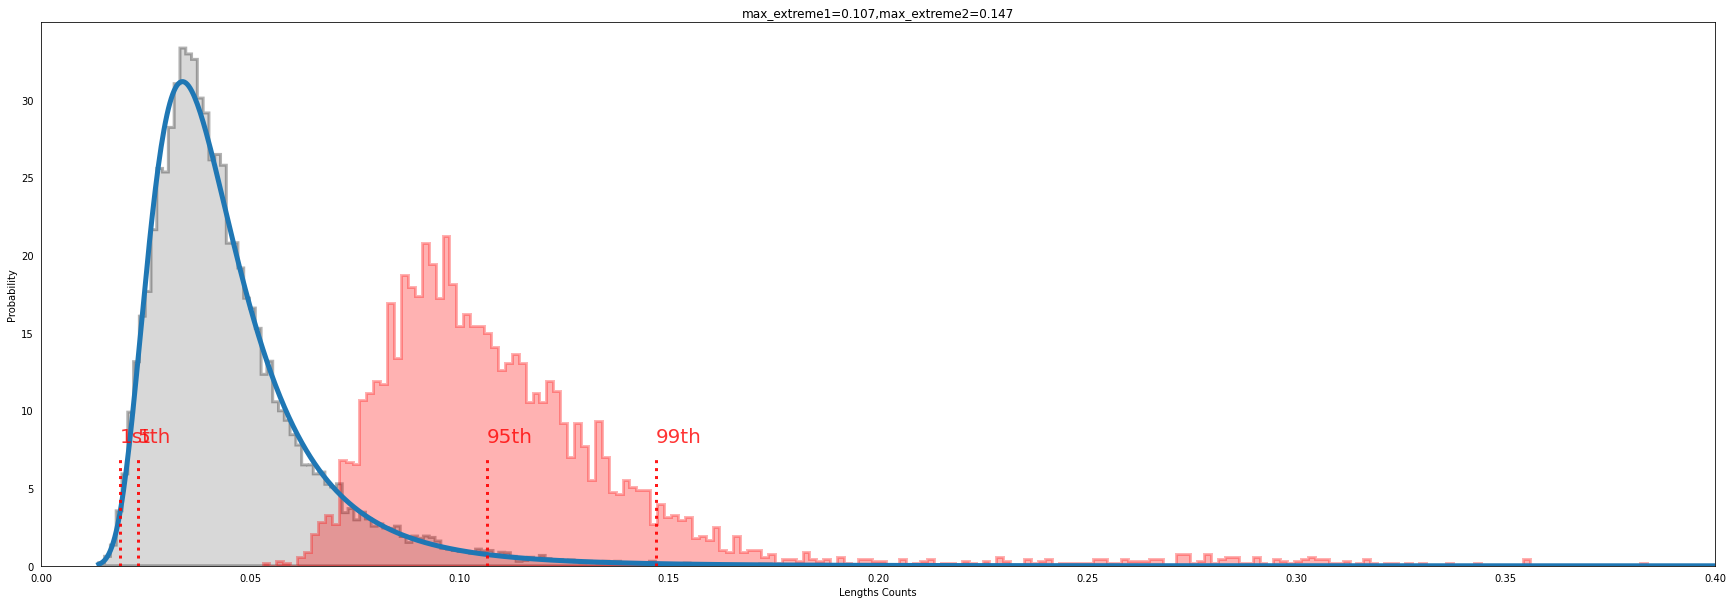

In [10]:
# Plot all training vs test histogram
# Change bin1 and bin2 as required
train=re_train_main
test=re_test_main
(c,log,scale,fig,ax)=Plot_Dist_Train_Extreme(train,test,bin1=500,bin2=200,interval1=0.95,interval2=0.99)

In [11]:
# Save distribution image
fig.savefig("../ExampleOutputs/gtu.hist.svg",dpi=300)

95% CI upper bound: 0.10659970165381911
99% CI upper bound: 0.14685000308245982
Median RE: 0.08736687898635864


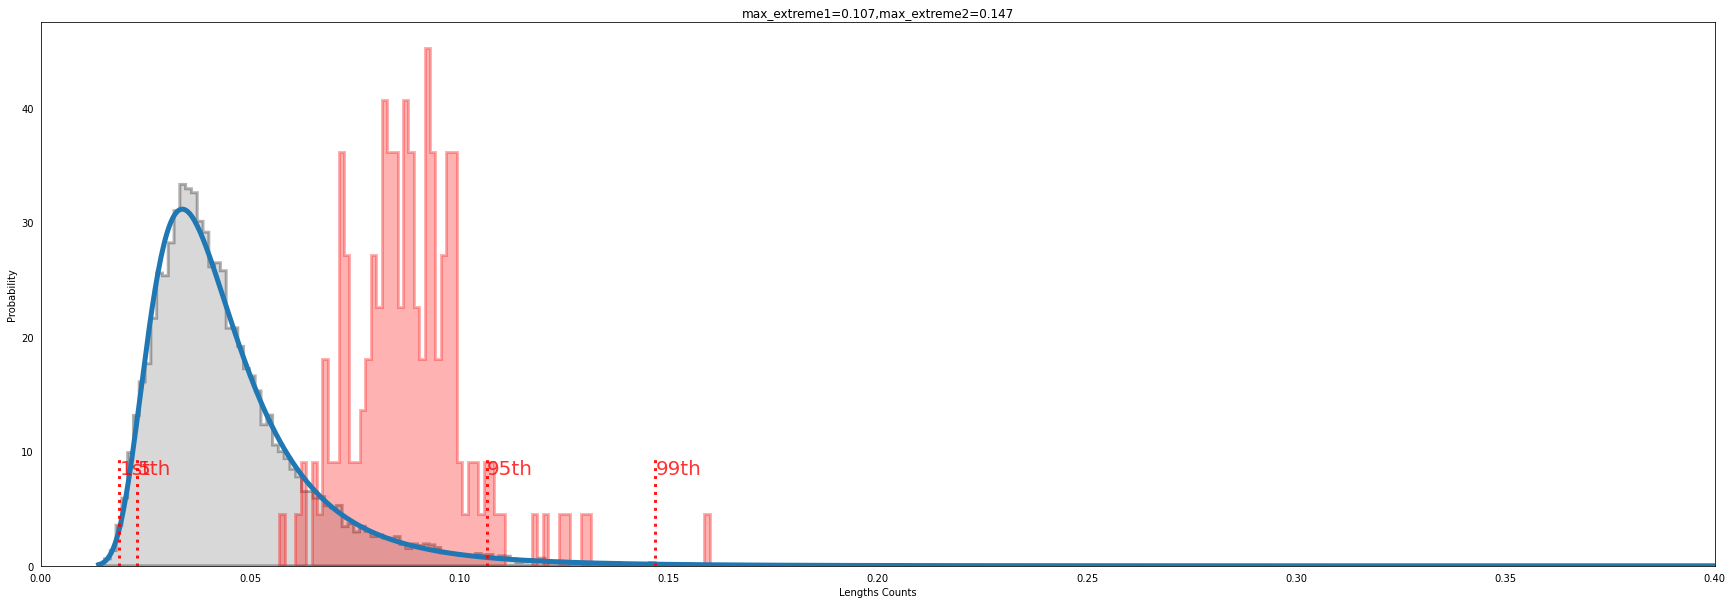

In [12]:
# Plot all training vs RE for selected families
# Change bin1 and bin2 as required
train=re_train_main
test=re_test_main.loc[re_test_main['Family']=='GT110-u']
(c,log,scale,fig,ax)=Plot_Dist_Train_Extreme(train,test,bin1=500,bin2=80,interval1=0.95,interval2=0.99)

In [13]:
# Save image with appropriate name
fig.savefig("../ExampleOutputs/GT110.hist.svg",dpi=300)

In [14]:
re_train_main

Family       Err
0      GT51-lyso  0.026972
1      GT51-lyso  0.024585
2      GT51-lyso  0.072289
3      GT51-lyso  0.021156
4      GT51-lyso  0.024445
...          ...       ...
24887     GT66-C  0.036941
24888     GT22-C  0.034056
24889     GT22-C  0.041673
24890     GT66-C  0.060316
24891     GT83-C  0.061984

[24892 rows x 2 columns]

#### Boxplot

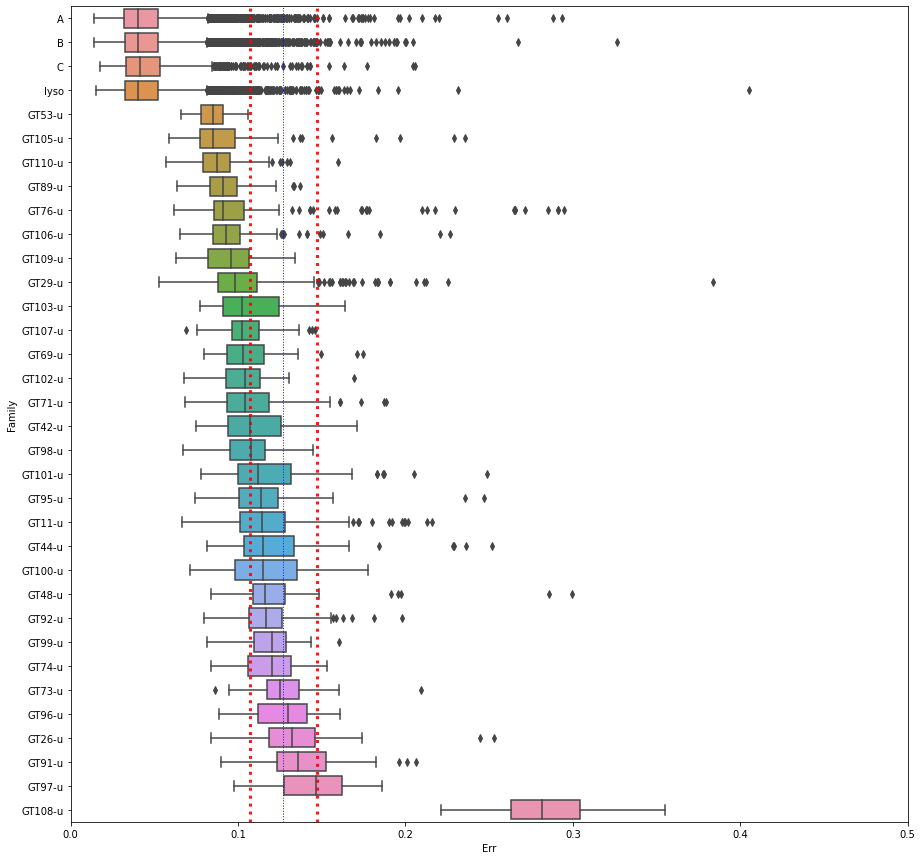

In [15]:
## Generate a boxplot with both training and testing data
g=gen_boxplot(re_train_main,re_test_main)

In [16]:
# Save boxplot to image file
g.figure.savefig("../ExampleOutputs/all_gtu.boxplot.svg",dpi=300)

## RE calculation and analysis against 9 cluster autoencoders

In [17]:
# Calculate RE against cluster autoencoders
# This step can take long; 
# To avoid, load already provided dataset by uncommenting last line of this block 
# and comment the lines below
re_test=dict()
for i in grp:
    re_test[i] = reconstruction_error_calculation(model[i], df_test, le_fam, le_fold, cuda_gpu, criterion, vocab)

# re_test=dict()
# for i in grp:
#     unknown="../Datasets/gtu/gtu.RE_"+i+".csv"
#     re_test[i]=pd.read_csv(unknown)

/Users/rtaujale/opt/anaconda3/envs/GTstrML/lib/python3.7/site-packages/torch/nn/functional.py:1639: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


In [18]:
# Save RE for every cluster into separate files
for i in grp:
    outfile="../ExampleOutputs/gtu.RE_"+i+".csv"
    re_test[i].to_csv(outfile,index=False)

### RE analysis for cluster autoencoders

#### Plotting distributions

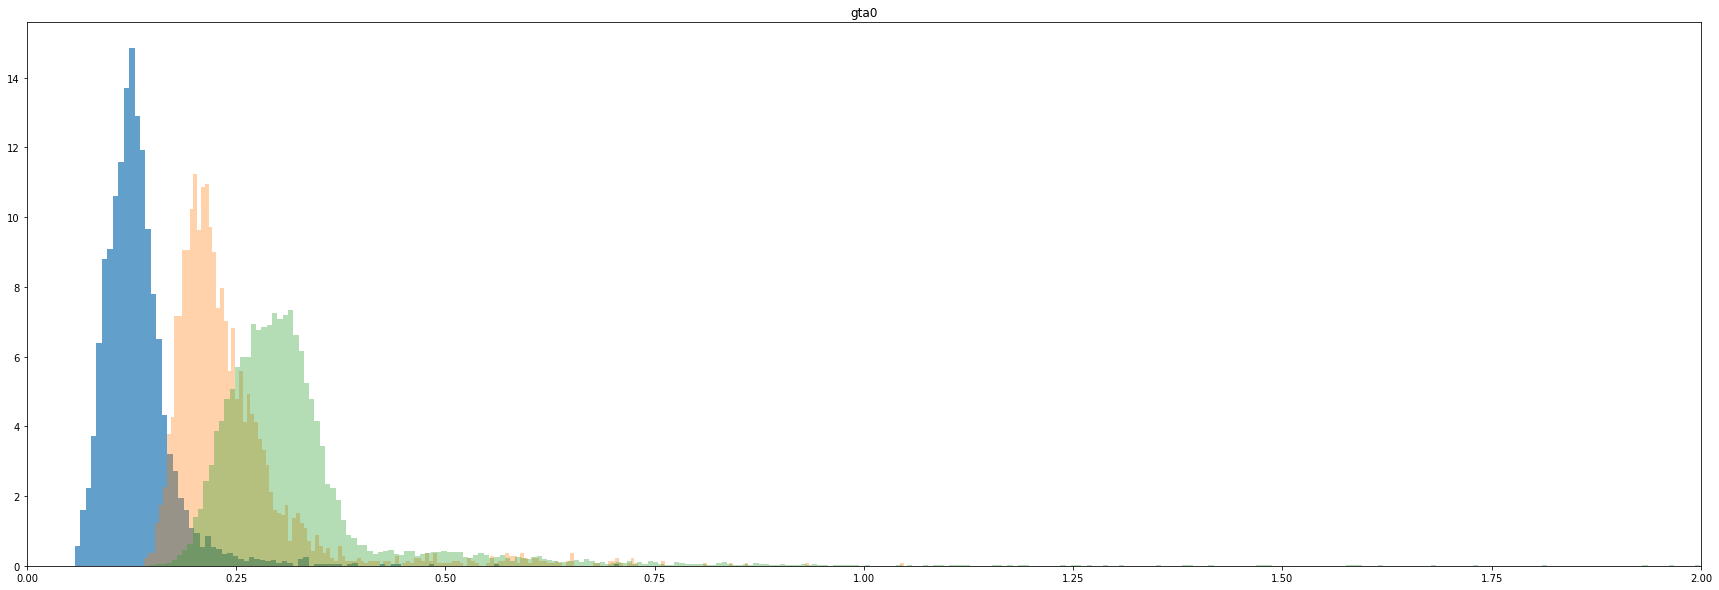

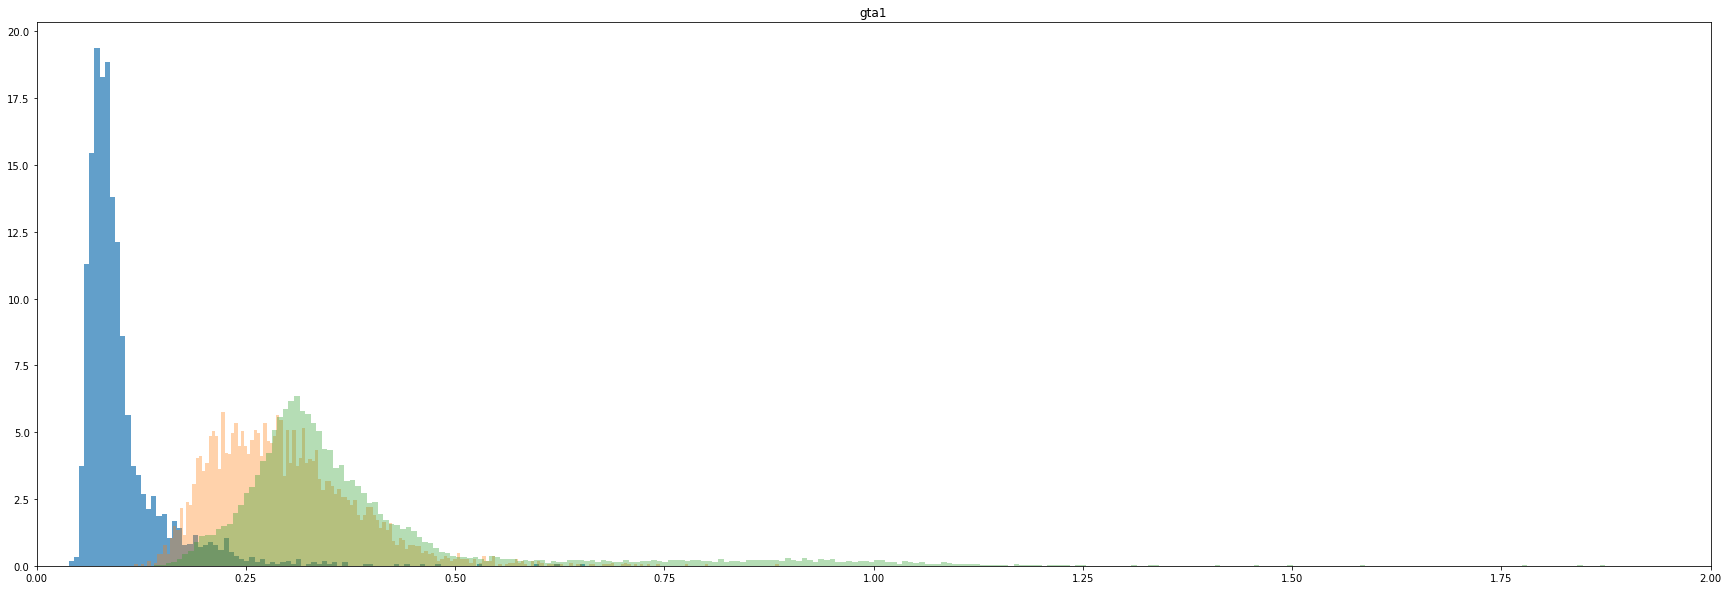

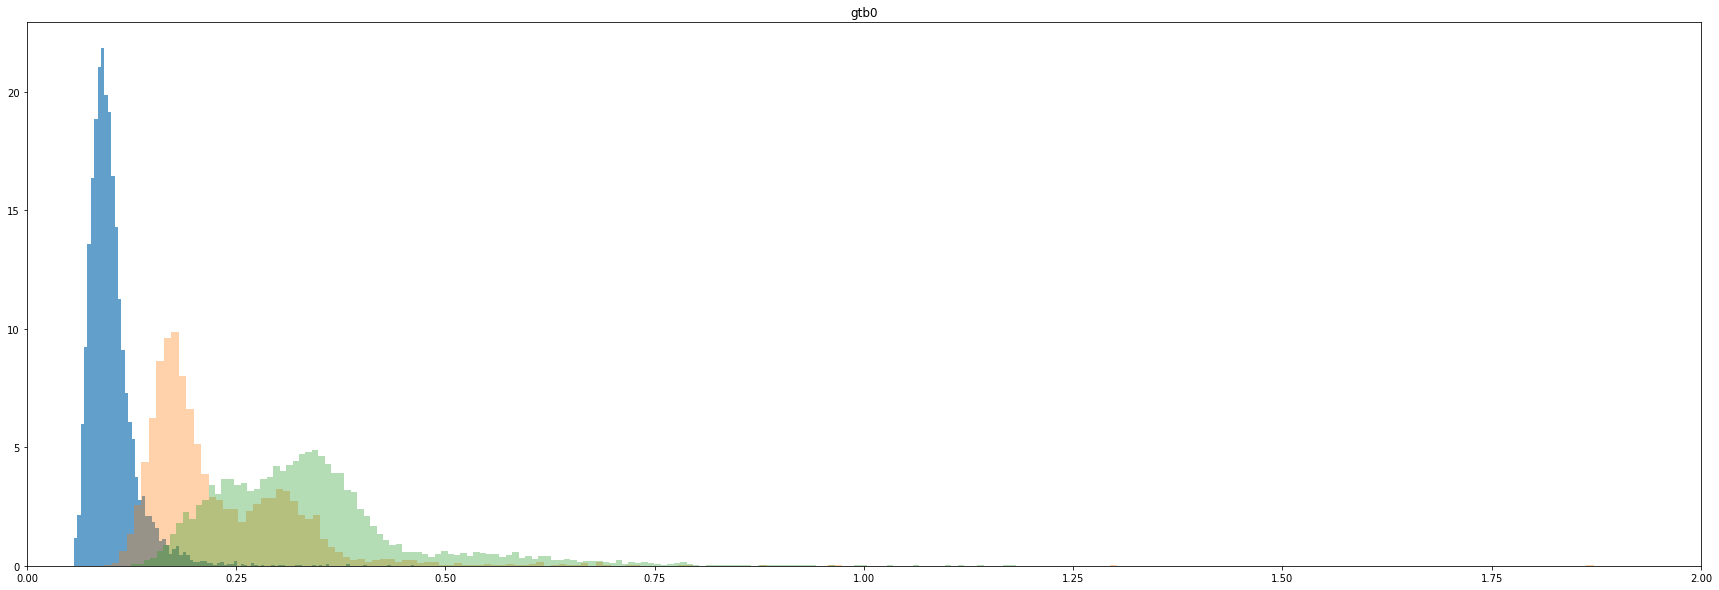

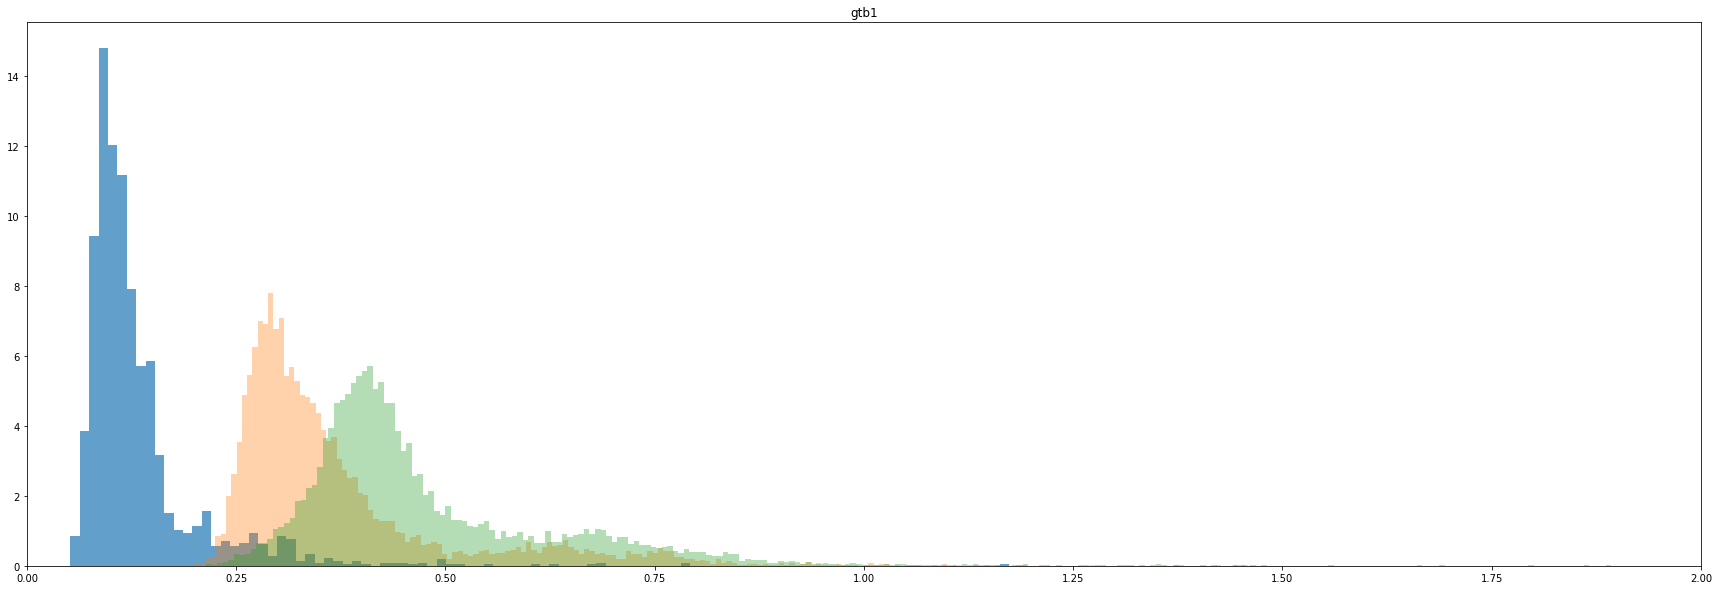

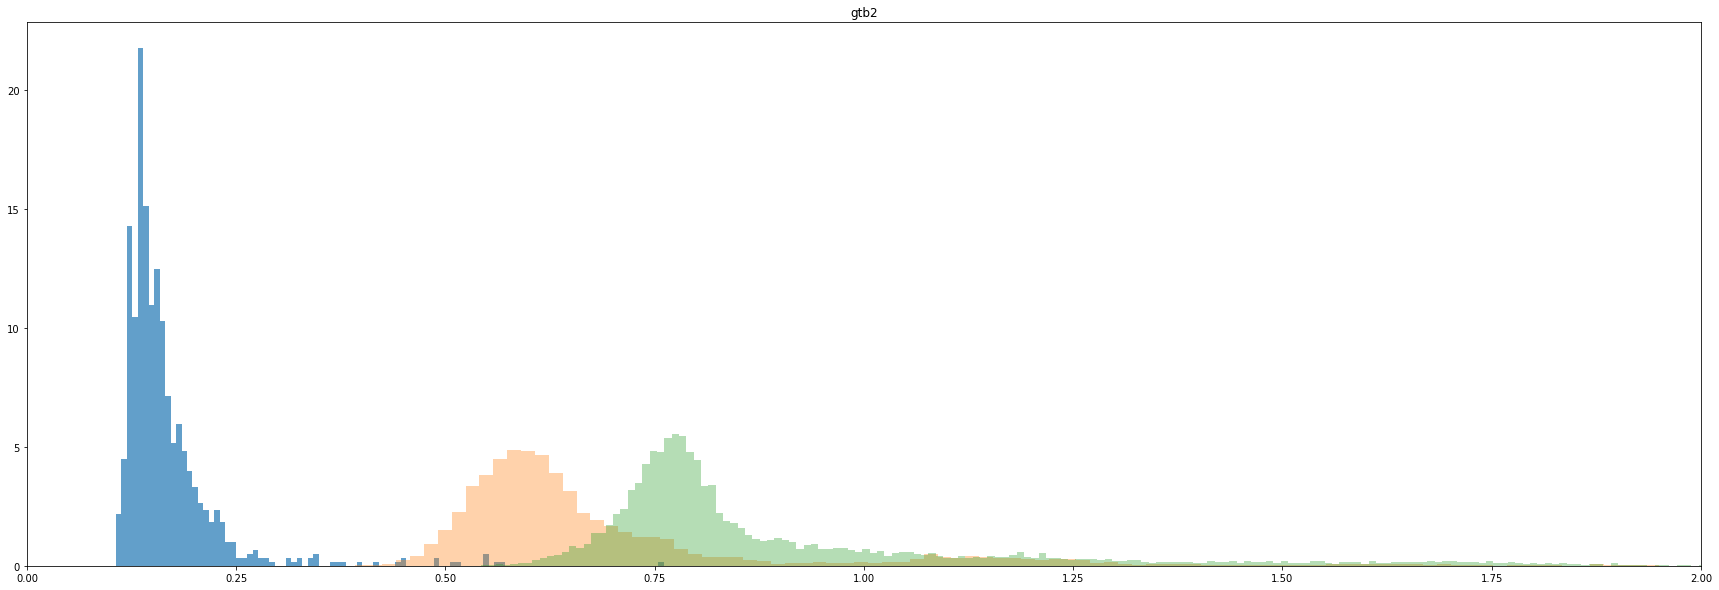

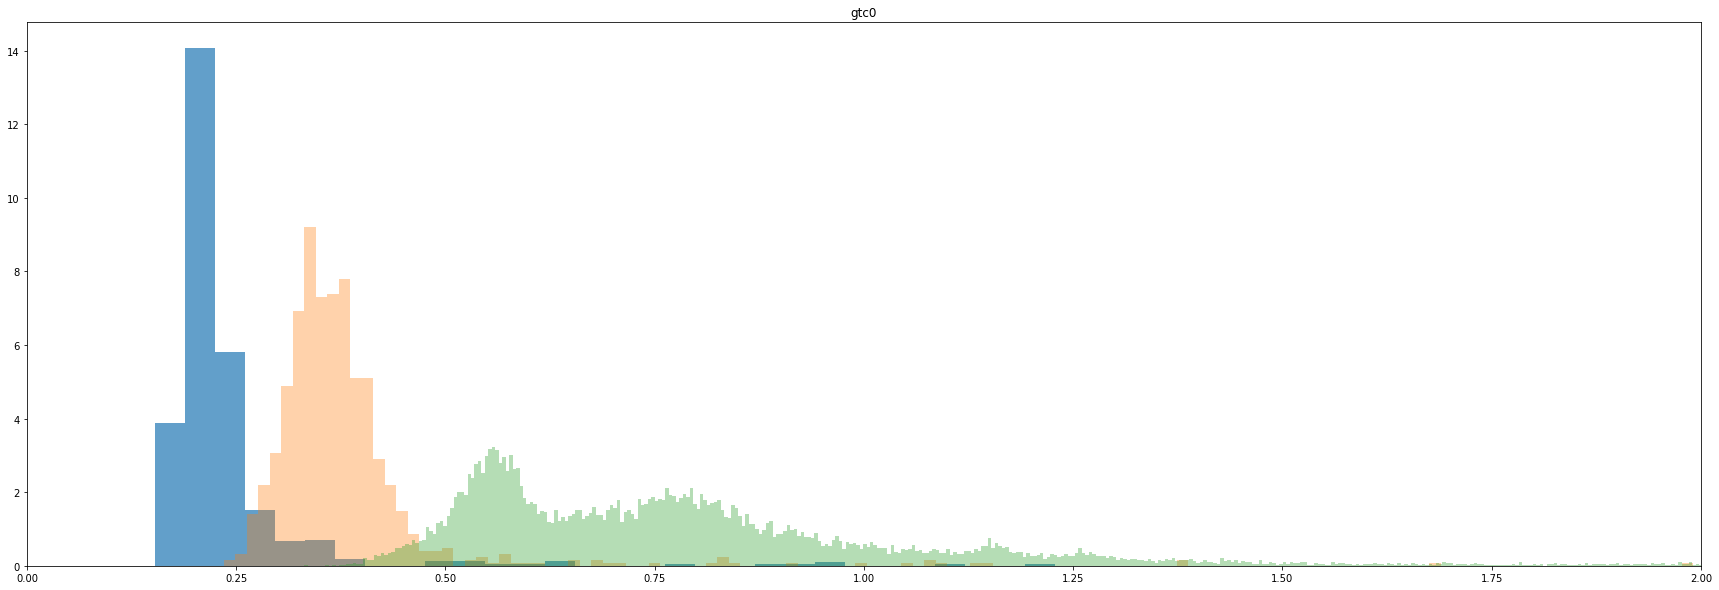

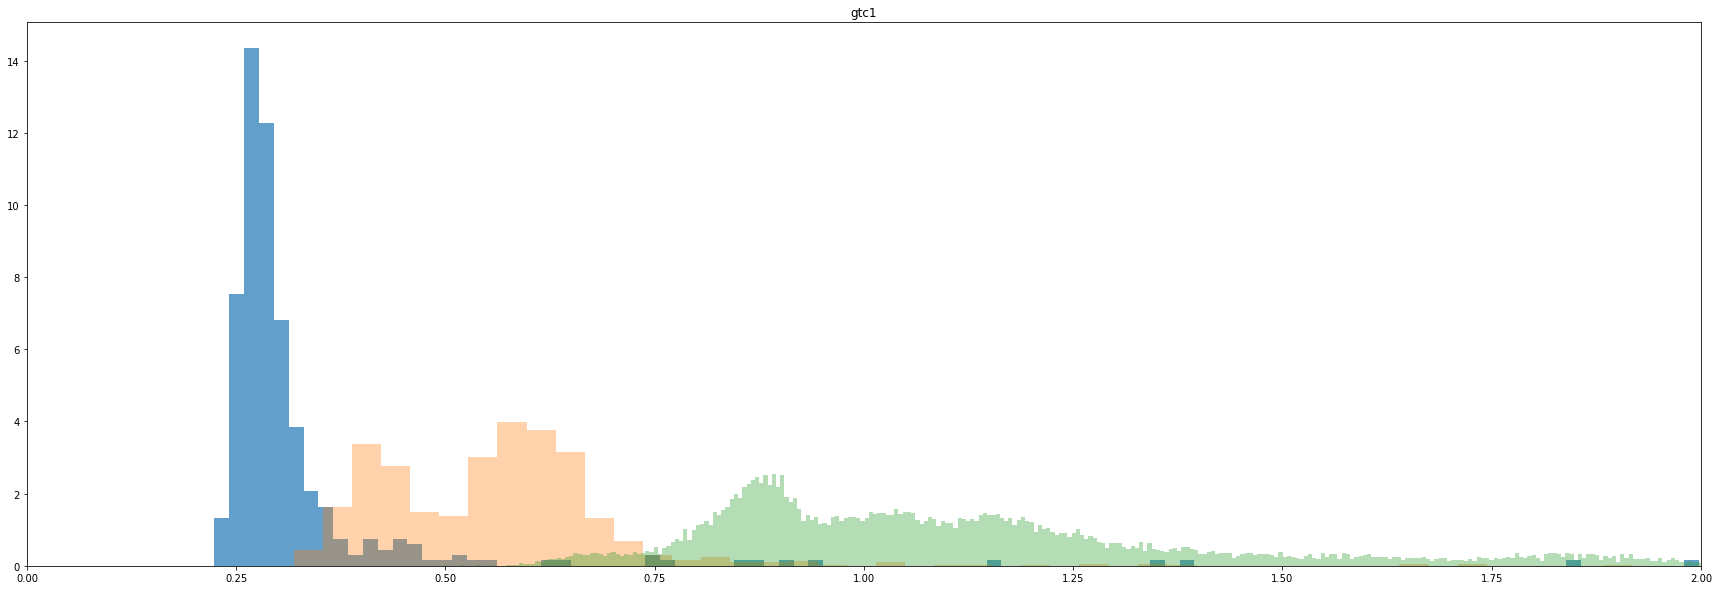

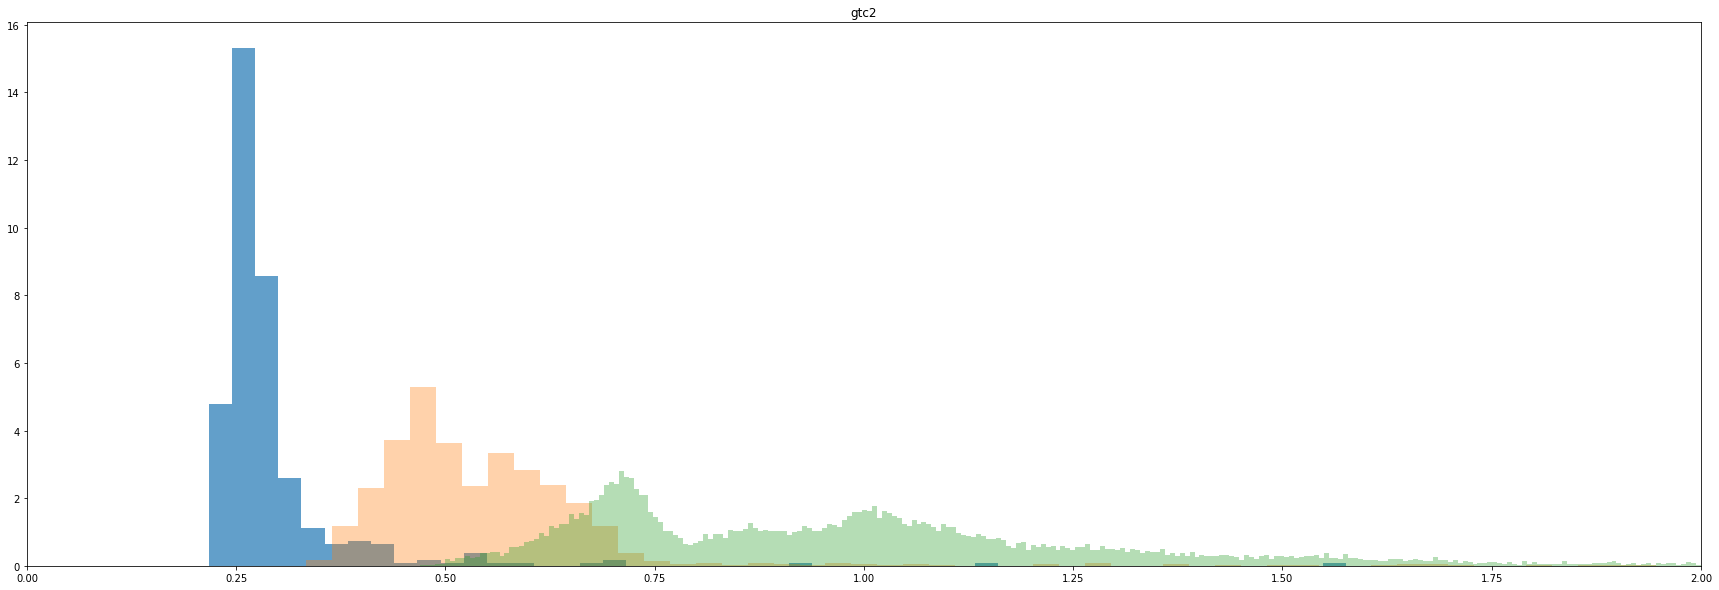

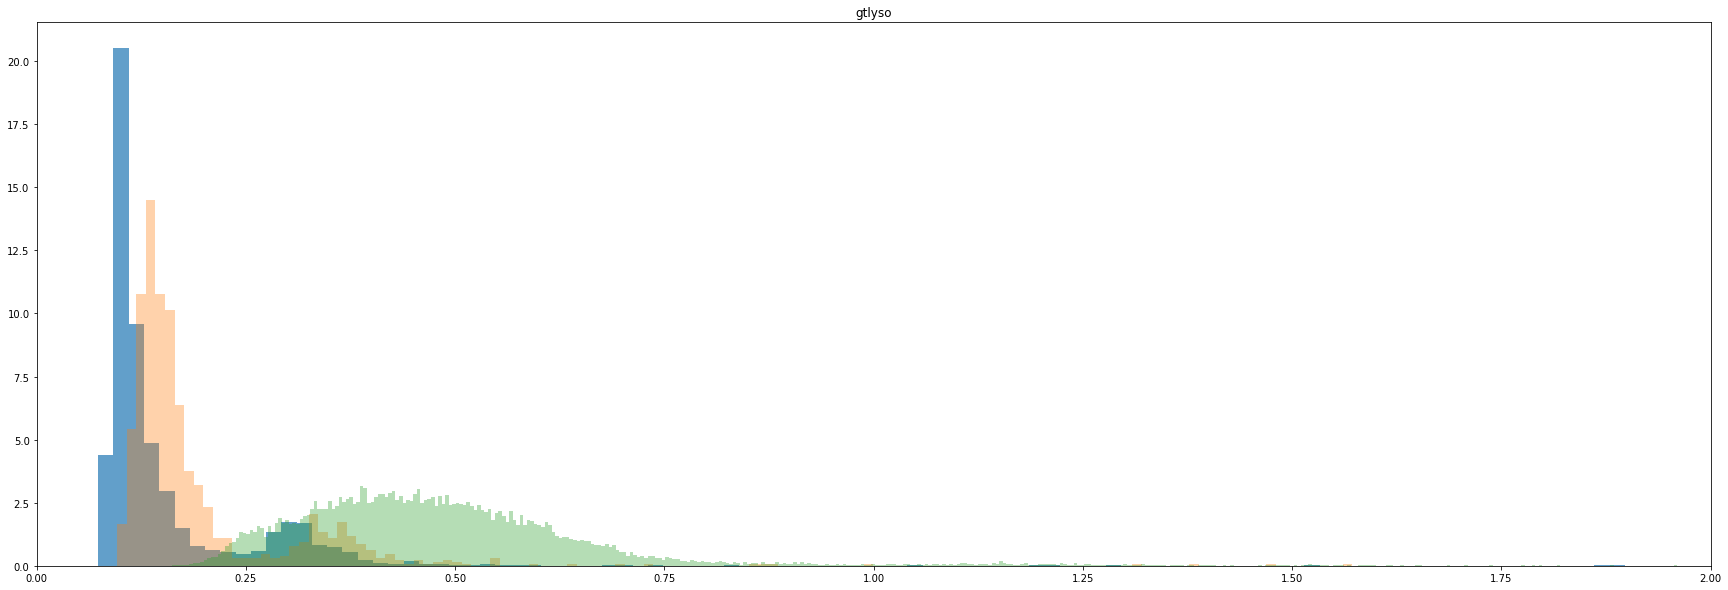

In [19]:
# Plot all clusters
for i in grp:
    plt.figure(figsize=(30,10))
    plt.hist(np.asarray(re_train[i]["Err"], dtype=float),bins=100,alpha=0.7, density=True)
    plt.hist(np.asarray(re_ooc[i]["Err"]), alpha=0.35, bins=200, density=True)
    plt.hist(np.asarray(re_oof[i]["Err"]), alpha=0.35, bins=1000, density=True)
    plt.xlim(0,2)
    plt.title(i)
    plt.close
    figname="../ExampleOutputs/autoencoder_sub_dist"+i+".svg"
    plt.savefig(figname,dpi=300)

#### Generate SC, OOC and OOF values

In [20]:
# Calculate mean or median values for each RE distribution
re_values=dict()
re_values['SC']=dict()
re_values['OOC']=dict()
re_values['OOF']=dict()
for i in grp:
    re_values['SC'][i]=re_train[i].median().values[0]
    re_values['OOC'][i]=re_ooc[i].mean().values[0]
    re_values['OOF'][i]=re_oof[i].mean().values[0]

re_values

{'SC': {'gta0': 0.1258273422718048,
  'gta1': 0.08553256094455719,
  'gtb0': 0.09493278712034224,
  'gtb1': 0.11197581887245178,
  'gtb2': 0.1497340202331543,
  'gtc0': 0.21322201192379,
  'gtc1': 0.28307750821113586,
  'gtc2': 0.26864010095596313,
  'gtlyso': 0.11339077353477478},
 'OOC': {'gta0': 0.24364851573095894,
  'gta1': 0.2953052853919425,
  'gtb0': 0.2276490337960422,
  'gtb1': 0.3727700505778799,
  'gtb2': 0.7066207815627319,
  'gtc0': 0.3917275443592761,
  'gtc1': 0.5887653968946496,
  'gtc2': 0.5867838928576794,
  'gtlyso': 0.1973829814041867},
 'OOF': {'gta0': 0.3223292794058654,
  'gta1': 0.38974644056127133,
  'gtb0': 0.3444296994562847,
  'gtb1': 0.48088257950931906,
  'gtb2': 0.9202121077084429,
  'gtc0': 0.7952218985533586,
  'gtc1': 1.168456332921431,
  'gtc2': 1.018041508801583,
  'gtlyso': 0.4814248231262168}}

#### Calculate Fold Assignment Score (FAS)

In [21]:
testHere=re_test
col='Family'
allgtu=list()
allgtu.append(testHere[i].groupby(col).mean().reset_index()[col].tolist())
grpname=['Fam']
for i in grp:
    grpname.append(i)
    allgtu.append(testHere[i].groupby(col).mean()['Err'].tolist())
gtu_resub=pd.DataFrame(np.asarray(allgtu).T, columns=grpname)
gtu_resub

Fam                 gta0                 gta1                 gtb0  \
0   GT100-u   0.3159002266500307   0.3549318783309149  0.22252751206574234   
1   GT101-u   0.2936458657072349  0.33123074150220916  0.21269776062531906   
2   GT102-u  0.27937214768358637   0.3194024456398828  0.17858357301780156   
3   GT103-u  0.23235464468598366  0.26009945571422577  0.20168168023228644   
4   GT105-u   0.6473673984811112     1.04222759403087   0.7800691603003321   
5   GT106-u  0.23057196232816374  0.24194326598721722  0.17490760470985936   
6   GT107-u  0.25116106034733177   0.2614165759227407  0.17563013356970988   
7   GT108-u   0.5227238578025741    0.636598380527111   0.7892442044585642   
8   GT109-u   0.2059736324079109   0.2323379638520154  0.19254452712608106   
9    GT11-u   0.3079517099476812   0.3750078948655925  0.23207092426364262   
10  GT110-u    0.194655766840591  0.18148153860035332  0.16166393749069335   
11   GT26-u   0.3284138336996822  0.47864195901681394  0.21851180241826704   
12   GT29-u  0.25125161372735855   0.2371394846527303  0.19979713964657705   
13   GT42-u  0.26658069147513463  0.31155660633857435  0.21733646507446583   
14   GT44-u   0.3187031949821271  0.48202458220092875  0.27899261995365743   
15   GT48-u  0.26258195947636576   0.3912178451085792  0.29488357342779636   
16   GT53-u   0.4011428928085667   0.8011081375573811   0.6337064504623413   
17   GT69-u  0.21429982578212564  0.20572316714308478  0.23041368208148263   
18   GT71-u  0.22416258571577855  0.23337171361094616   0.2231325815935604   
19   GT73-u  0.29174798148973236   0.3050383224055685  0.24861214374159946   
20   GT74-u  0.24555162290732066   0.2726013580958048  0.28065938254197437   
21   GT76-u   0.6846826996926855   1.1037382841473673   0.8219220189423095   
22   GT89-u  0.25074213563368236  0.40133746058262626  0.31943543377364503   
23   GT91-u   0.2642782368443229   0.2800736675208265  0.36349578621712597   
24   GT92-u   0.2345542871841678   0.2297740135755804   0.3001108833209232   
25   GT95-u  0.24906132729916736   0.2436050346185421  0.24576562925659376   
26   GT96-u   0.2596567902834185  0.26100507522782973   0.2641147211674721   
27   GT97-u   0.4001973792910576   0.4722333513200283  0.22553564049303532   
28   GT98-u   0.2984133882181985   0.4786321299416678   0.3928468657391412   
29   GT99-u  0.31069706769093225  0.36351707059404126  0.20813391843567725   

                   gtb1                gtb2                 gtc0  \
0    0.5031741449366445  0.8559442680814991   1.0438855199710182   
1    0.4125034539875659  0.8045272488485683   0.8823299231854352   
2   0.37107086713824955  0.6664829669254166    0.842444159090519   
3   0.31569230407476423  0.6356155693531036   0.6280426576733589   
4    0.5329506733530277  1.2791469169629586  0.42519599299978567   
5    0.3359430643733228  0.6854021363094825   0.6482466521676267   
6    0.3199436324318563  0.6004484873118363   0.6605265806979081   
7     1.511333005596893  1.8208019492602108    1.731743057568868   
8   0.31709443800377124  0.7041792219335382   0.6700647175312042   
9    0.5289830150375342  0.9419320224229237   1.0895429630380615   
10  0.39925176494343334  0.6258705190794412   0.7874697980492614   
11   0.5276461489608183  0.9613345195265377   1.0038518171538324   
12   0.4657686716220418   0.799091706705875   0.8665940383907225   
13  0.42596529768063474  0.8578179020148057   0.8658576635213998   
14  0.38944896467422185  0.9995756941406351    0.770278714989361   
15  0.32634319222586994  0.8140344317345058   0.5001765274826218   
16  0.44301554246952657  1.0816124310860267  0.34772753244952154   
17  0.44391537525437097  0.7785801426930861    0.807895302772522   
18   0.3409186714496769   0.701152889259526     0.60617010427303   
19   0.5303907998163124  0.9538119872068537    1.047826686809803   
20   0.5219541907310485  0.8950475692749024    0.937995187441508   
21   0.5196622377488671  1.3815933193375425   0.4351708629145855   
22  0.29740808236187904  

In [22]:
subscore1=gtu_resub.apply(calcSubScore,args=(re_values,), axis=1)
subscore1.columns=grp
subscore1.insert(loc=0, column='Fam', value=gtu_resub['Fam'])
subscore1=subscore1.set_index('Fam')
subscore1.style.highlight_max(color = 'lightgreen', axis = 1)

#### Plot distribution of specific GT-u families vs GT clusters

(0.0, 1.5)

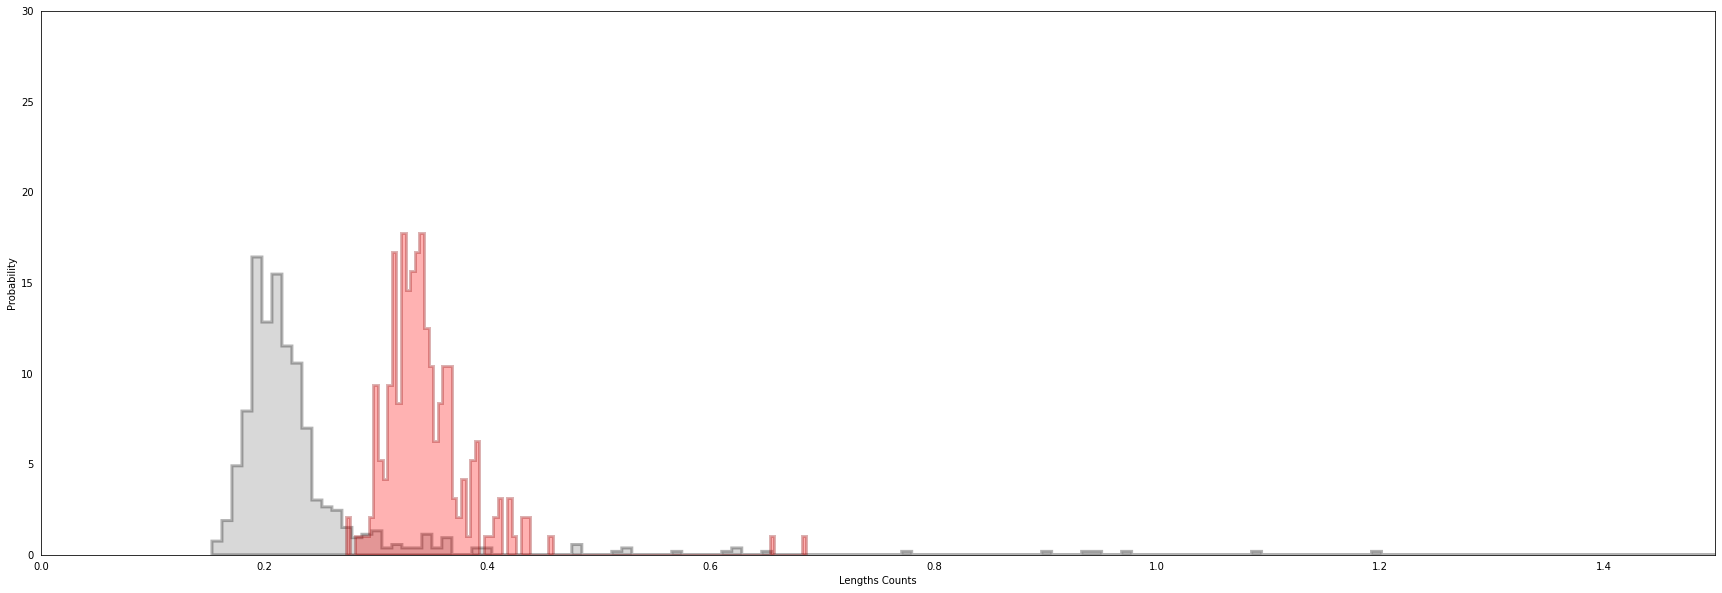

In [23]:
# Plot distribution of training vs test
scname='gtc0'
famname='GT89-u'
trainSC=re_train[scname]
# For plotting specific family within test results
test_here=re_test[scname]
testSC=test_here[test_here['Family'].str.contains(famname)]

(fig,ax)=Plot_Dist_SubClust_Extreme(trainSC,testSC,400,100)
ax.set_ylim(0,30)
ax.set_xlim(0,1.5)

In [24]:
# Save distribution as image
ax.figure.savefig("../ExampleOutputs/gtc0_gt89.svg",dpi=300)